## Import Everything

In [1]:
import h5py
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

### Load Data

In [3]:
cl_x_valid, cl_y_valid = data_loader('./data/cl/valid.h5')
cl_x_test, cl_y_test = data_loader('data/cl/test.h5')
bd_x_valid, bd_y_valid = data_loader('data/bd/bd_valid.h5')
bd_x_test, bd_y_test = data_loader('data/bd/bd_test.h5')
N = int(cl_y_test.max())

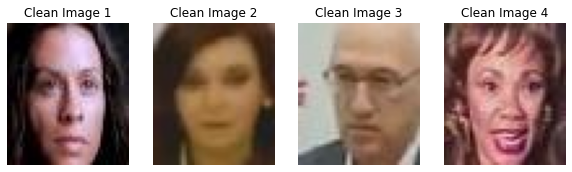

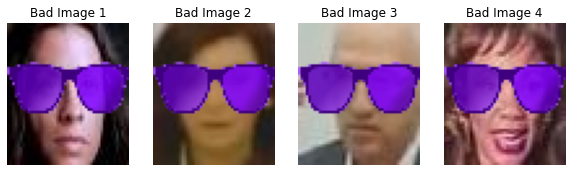

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5)) 
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.title(f"Clean Image {i+1}")
    plt.imshow(cl_x_valid[i].astype(np.uint8))

plt.show()


plt.figure(figsize=(10,5)) 
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.title(f"Bad Image {i+1}")
    plt.imshow(bd_x_valid[i].astype(np.uint8))

plt.show()

### Load Bad Net Model

In [5]:
bd_model = keras.models.load_model('models/bd_net.h5')

# confirm original accuracy
# python3 eval.py data/cl/valid.h5 data/bd/bd_valid.h5 models/bd_net.h5
# Clean Classification accuracy: 98.64 % Attack Success Rate: 100 %
def evalModel(model):
    cl_label_p = np.argmax(model.predict(cl_x_test), axis=1)
    acc = np.mean(np.equal(cl_label_p, cl_y_test))*100

    bd_label_p = np.argmax(model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    return acc, asr

acc, asr = evalModel(bd_model)
print('Clean Classification accuracy:', acc)
print('Attack Success Rate:', asr)

2022-12-09 19:13:16.240982: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-09 19:13:16.241834: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 19:13:16.242839: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-09 19:13:16.763291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-09 19:13:16.769011: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600050000 Hz


Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


In [6]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

# Create Good Model

In [7]:
def getGoodModel(bd_model, X):
    bd_bar_model = keras.models.clone_model(bd_model)
    bd_bar_model.set_weights(bd_model.get_weights())
    # original accuracy 
    cl_label_p = np.argmax(bd_model.predict(cl_x_valid), axis=1)
    original_acc = np.mean(np.equal(cl_label_p, cl_y_valid))*100
    
    # we need to drop one channel in conv_3 each time
    conv_3 = bd_bar_model.get_layer('conv_3')

    intermediate = keras.Model(inputs=bd_bar_model.input, outputs=conv_3.output)

    activation_values = intermediate.predict(cl_x_valid).sum(axis=(0, 1, 2))

    ordered_channels = np.argsort(activation_values)
    # # delete channels in order
    for channel in ordered_channels:
        conv_3_mod = np.array(conv_3.get_weights()[0])
        conv_3_mod[:, :, :, channel] = np.zeros((3, 3, 40))
        conv_3.set_weights(list([conv_3_mod, conv_3.get_weights()[1]]))

        cl_label_p_bar = np.argmax(bd_bar_model.predict(cl_x_valid), axis=1)

        preds = []
        for i in range(len(cl_label_p)):
            if cl_label_p[i] == cl_label_p_bar[i]:
                preds.append(cl_label_p_bar[i])
            else:
                preds.append(N + 1)
        preds = np.array(preds)

        new_acc = np.mean(np.equal(preds, cl_y_valid))*100

        if original_acc - new_acc > X:
            break

    return bd_bar_model

# Then acc and asr of drops in {2%,4%,10%}

In [8]:
def evalGoodModel(bd_bar_model, bd_model):
    # accuracy
    pred_bd_bar = np.argmax(bd_bar_model.predict(cl_x_test), axis=1)
    pred_bd = np.argmax(bd_model.predict(cl_x_test), axis=1)
    preds = []
    for i in range(len(pred_bd)):
        if pred_bd[i] == pred_bd_bar[i]:
            preds.append(pred_bd[i])
        else:
            preds.append(N + 1)
    preds = np.array(preds)    
    acc = np.mean(np.equal(preds, cl_y_test))*100

    # ASR
    pred_bd_bar = np.argmax(bd_bar_model.predict(bd_x_test), axis=1)
    pred_bd = np.argmax(bd_model.predict(bd_x_test), axis=1)
    preds = []
    for i in range(len(pred_bd)):
        if pred_bd[i] == pred_bd_bar[i]:
            preds.append(pred_bd[i])
        else:
            preds.append(N + 1)
    preds = np.array(preds)    
    asr = np.mean(np.equal(preds, bd_y_test))*100

    return acc, asr

In [9]:
# output the accuricy and asr when drops = {2%,4%,10%}

Xs = [2,4,10]

for X in Xs:
  # we can use the previous bd_bar_model since 
    bd_bar_model = getGoodModel(bd_model, X)
    acc, asr = evalGoodModel(bd_bar_model, bd_model)
    print(f'''drop = {X} 
            \n\tAccuracy of this Good Model = {acc} 
            \n\tAttack Success Rate on this G model = {asr}\n''')
    bd_bar_model.save(f"models/bd_prime_{X}.h5")



drop = 2 
            
	Accuracy of this Good Model = 95.8846453624318 
            
	Attack Success Rate on this G model = 100.0

drop = 4 
            
	Accuracy of this Good Model = 94.61418550272798 
            
	Attack Success Rate on this G model = 99.97661730319564

drop = 10 
            
	Accuracy of this Good Model = 84.45830085736556 
            
	Attack Success Rate on this G model = 76.1730319563523

